In [1]:
import os 

# os.environ['GO_EMOTIONS_COLAB_WORKDIR'] = '/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks'
colab_workdir = os.environ.get('GO_EMOTIONS_COLAB_WORKDIR')

if colab_workdir:
    print('Running with colab')
    from google.colab import drive
    drive.mount('/content/drive')
    %cd $colab_workdir
    !pip install -q -r ../requirements.txt
else:
    print('Running with jupyter notebook')

Running with colab
Mounted at /content/drive
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks
     |████████████████████████████████| 3.8 MB 11.9 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 6.5 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 


In [2]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from torch import Tensor
import torch.nn as nn
from attrdict import AttrDict

tqdm.pandas()

with open('go-emotion-pool.py', 'r') as f:
    exec(f.read())
    
with open('go-emotion-gru.py', 'r') as f:
    exec(f.read())

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
arg1 = load_args('go-emotion-pool-default', 'variant_pool_small', device=device)
arg2 = load_args('go-emotion-gru-default', 'variant_gru_small', device=device)

device: cuda
device: cuda


In [4]:
metrics = [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
]

df_pool = get_attrs_from_checkpoints_meta(
    arg1.output_dir, 
    arg1.model_name, 
    metrics)

df_gru = get_attrs_from_checkpoints_meta(
    arg2.output_dir, 
    arg2.model_name, 
    metrics)

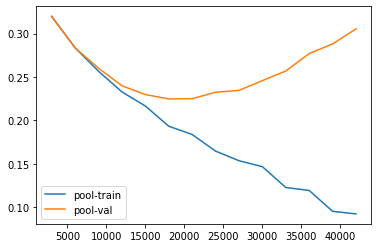

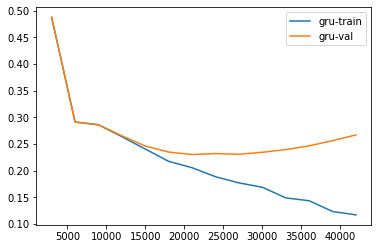

In [12]:
plt.plot(df_pool['checkpoint_id'], df_pool['tr_metrics.loss'], label='pool-train')
plt.plot(df_pool['checkpoint_id'], df_pool['val_metrics.loss'], label='pool-val')
plt.legend()
plt.show()
plt.plot(df_gru['checkpoint_id'], df_gru['tr_metrics.loss'], label='gru-train')
plt.plot(df_gru['checkpoint_id'], df_gru['val_metrics.loss'], label='gru-val')
plt.legend()
plt.show()

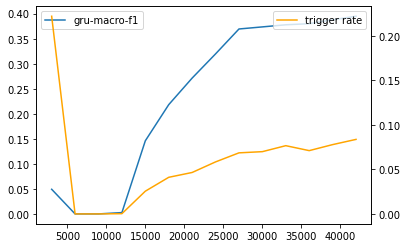

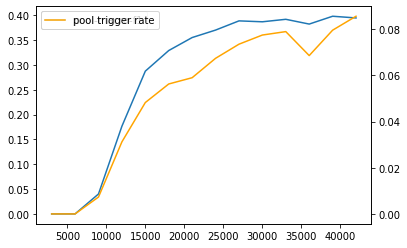

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(df_gru['checkpoint_id'], df_gru['val_metrics.macro_f1'], label='gru-macro-f1')
ax2.plot(df_gru['checkpoint_id'], df_gru['val_metrics.trigger_rate'], label='trigger rate', c='orange')

# plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.macro_f1'][3:], label='pool-macro-f1')
ax1.legend()
ax2.legend()

plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(df_pool['checkpoint_id'], df_pool['val_metrics.macro_f1'], label='pool-macro-f1')
ax2.plot(df_pool['checkpoint_id'], df_pool['val_metrics.trigger_rate'], label='pool trigger rate', c='orange')

# plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.macro_f1'][3:], label='pool-macro-f1')
ax1.legend()
ax2.legend()

plt.show()

In [25]:
def get_best_checkpoint(archive_dir, model_name, compare_by=None):
  best_checkpoint = None
  best_meta = None

  if compare_by is None:
    # if b is greater than a => return True
    compare_by = lambda a, b: a['val_metrics']['macro_f1'] < b['val_metrics']['macro_f1']

  for module in os.listdir(os.path.join(archive_dir, model_name)):
    if 'null-model' in module:
      continue

    checkpoint_id = module.split('-')[-1]
    metadata = load_from_checkpoint(archive_dir, model_name, checkpoint_id=checkpoint_id, 
                                    load_tokenizer=False, load_metadata=True, 
                                    load_optimizer=False, load_model=False)[0]
    if best_meta is None:
      best_checkpoint = checkpoint_id
      best_meta = metadata
    else:
      is_better = compare_by(best_meta, metadata)
      best_checkpoint = checkpoint_id if is_better else best_checkpoint
      best_meta = metadata if is_better else best_meta
  
  return best_checkpoint, best_meta

checkpoint_id, meta = get_best_checkpoint(arg1.output_dir, arg1.model_name)
checkpoint_id

'39000'

In [26]:
ge_pool, meta_ge_pool = load_from_checkpoint(
    arg1.output_dir, 
    arg1.model_name, 
    checkpoint_id=get_best_checkpoint(arg1.output_dir, arg1.model_name)[0], 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionPoolClassifer
)

In [27]:
ge_gru, meta_ge_gru = load_from_checkpoint(
    arg2.output_dir, 
    arg2.model_name, 
    checkpoint_id=get_best_checkpoint(arg2.output_dir, arg2.model_name)[0], 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionGRUClassifer
)

In [28]:
def total_params(model):
    n = 0
    for p in model.parameters():
        n += p.nelement()
    return n 

In [31]:
total_params(ge_gru) - total_params(ge_pool)

120400

In [32]:
tokenizer = AutoTokenizer.from_pretrained(arg2.encoder_name)
encoder = AutoModel.from_pretrained(arg2.encoder_name)

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
test_dataset = generate_bert_dataset(
    os.path.join(
        arg2.output_dir, 
        arg2.test_dataset_path), 
    tokenizer, 
    arg2.emotions, 
    arg2.sentence_max_len, 
)
y_true = test_dataset[:]['y_true'].numpy()
y_true.shape

(10748, 27)

In [44]:
proba1 = predict_proba(ge_pool, test_dataset, 
                       batch_size=64,device=device, back_to_cpu=True)
results = compute_classification_metrics_per_class(
    y_true, 
    proba1, 
    [arg1.classification_threshold] * y_true.shape[-1]
)
print(meta_ge_gru['val_metrics'])

df = pd.DataFrame(results)
df.index = arg1.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']]#.to_latex(index=True, header=True,)

evaluation:   0%|          | 0/168 [00:00<?, ?it/s]

{'loss': 0.2668965343372086, 'trigger_rate': 0.08377804482002645, 'accuracy': 0.9049243452080992, 'auc_roc_macro': 0.7959992846422032, 'auc_roc_micro': 0.8365825953119318, 'macro_precision': 0.4824365660877955, 'macro_recall': 0.3755191886919827, 'macro_f1': 0.39479700330718553, 'micro_precision': 0.4805922574674824, 'micro_recall': 0.43848210516440733, 'micro_f1': 0.45857247976453275, 'weighted_precision': 0.47918462751651575, 'weighted_recall': 0.43848210516440733, 'weighted_f1': 0.44786412812283904}


,precision,f1,trigger_rate,auc_roc
admiration,0.60,0.59,0.17,0.85
amusement,0.67,0.68,0.10,0.94
anger,0.58,0.47,0.07,0.91
annoyance,0.45,0.40,0.15,0.80
approval,0.41,0.46,0.31,0.69
caring,0.43,0.38,0.06,0.91
confusion,0.45,0.40,0.08,0.90
curiosity,0.65,0.65,0.11,0.92
desire,0.42,0.28,0.03,0.94
disappointment,0.35,0.29,0.09,0.85


In [43]:
proba2 = predict_proba(ge_gru, test_dataset, 
                       batch_size=64,device=device, back_to_cpu=True)
results = compute_classification_metrics_per_class(
    y_true, 
    proba2, 
    [arg2.classification_threshold] * y_true.shape[-1]
)
print(meta_ge_gru['val_metrics'])

df = pd.DataFrame(results)
df.index = arg2.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']]#.to_latex(index=True, header=True,)

evaluation:   0%|          | 0/168 [00:00<?, ?it/s]

{'loss': 0.2668965343372086, 'trigger_rate': 0.08377804482002645, 'accuracy': 0.9049243452080992, 'auc_roc_macro': 0.7959992846422032, 'auc_roc_micro': 0.8365825953119318, 'macro_precision': 0.4824365660877955, 'macro_recall': 0.3755191886919827, 'macro_f1': 0.39479700330718553, 'micro_precision': 0.4805922574674824, 'micro_recall': 0.43848210516440733, 'micro_f1': 0.45857247976453275, 'weighted_precision': 0.47918462751651575, 'weighted_recall': 0.43848210516440733, 'weighted_f1': 0.44786412812283904}


,precision,f1,trigger_rate,auc_roc
admiration,0.57,0.61,0.21,0.84
amusement,0.76,0.69,0.08,0.95
anger,0.44,0.46,0.12,0.88
annoyance,0.42,0.44,0.21,0.78
approval,0.45,0.44,0.24,0.72
caring,0.38,0.37,0.07,0.90
confusion,0.43,0.43,0.09,0.89
curiosity,0.62,0.65,0.12,0.92
desire,0.40,0.30,0.03,0.94
disappointment,0.35,0.31,0.10,0.84
